In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import numpy as np

import os

In [27]:
def build_corpus(folder_path: str) -> list:
    """
    Given a directory of text files, builds a corpus of
    sentences that can be used to train neural networks.
    """
    corpus = []

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".txt"):
                full_path_to_file = root + "/" + filename
                with open(full_path_to_file, 'r') as infile:
                    lines = infile.read().split('\n')
                    corpus += lines
    
    # deduplicating because I'm getting weird prediction results
    corpus = list(set(corpus))

    return corpus

In [28]:
corpus = build_corpus("./corpus")

In [29]:
# no need for an OOV token, since we'll be training using the entire corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_words = len(word_index) + 1

In [30]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [31]:
xs = input_sequences[:,:-1]
labels = input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [32]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)

Train on 3486 samples
Epoch 1/100


2021-11-18 12:52:01.504294: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_11263_11748' and '__inference___backward_standard_lstm_11263_11748_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_12439' both implement 'lstm_8d3d9827-5871-43cb-8247-85cadfabd14c' but their signatures do not match.


3486/3486 [==============================] - 9s 3ms/sample - loss: 6.0701 - accuracy: 0.0384
Epoch 2/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 4.9524 - accuracy: 0.1489
Epoch 3/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 3.7504 - accuracy: 0.3101
Epoch 4/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 2.7294 - accuracy: 0.4234
Epoch 5/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 1.8869 - accuracy: 0.5631
Epoch 6/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 1.2919 - accuracy: 0.6933
Epoch 7/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 0.9696 - accuracy: 0.7605
Epoch 8/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 0.7481 - accuracy: 0.8087
Epoch 9/100
3486/3486 [==============================] - 6s 2ms/sample - loss: 0.6466 - accuracy: 0.8262
Epoch 10/100
3486/3486 [==============================] - 6s 2ms/sa

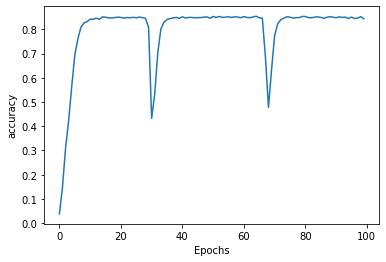

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [51]:
seed_text = "Dead leaves and the dirty ground"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# predicted = model.predict_classes(token_list, verbose=0)
	predict_x=model.predict(token_list) 
	classes_x=np.argmax(predict_x,axis=1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == classes_x:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Dead leaves and the dirty ground and laying nobody's praying oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh
